In [1]:
spark

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import io
from google.cloud import storage

In [2]:
from pyspark.sql.functions import col, isnan, isnull, when, count, udf, size, split, year, month, format_number, date_format, length
from pyspark.sql.types import IntegerType, DateType, StringType, StructType, DoubleType
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, Normalizer, MinMaxScaler, StandardScaler, HashingTF, IDF, Tokenizer, RegexTokenizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import DataFrame
from functools import reduce
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation

In [31]:
def read_data(): 
    ## Read Data
    # Read in all files in the cleaned folder
    sdf = spark.read.parquet("gs://my-project-bucket-flights-cl/cleaned/")

    # Take a small sample for demonstration purposes
    #sdf = sdf.sample(withReplacement=False, fraction=0.10, seed=42)

    # Check the schema
    print(sdf.printSchema())

    # Get the number of records in the dataframe
    print("# columns and rows")
    print(len(sdf.columns))
    print(sdf.count())

    return sdf

In [32]:
def clean_data(sdf):
    print("Raw count (before dropna):", sdf.count())
    sdf.limit(5).show()
    
    sdf = sdf.drop("DivAirportLandings")
    
    # Check to see records where ArrDel15 are null
    print(sdf.select([count(when(col(c).isNull(), c)).alias(c) for c in ["ArrDel15"]] ).show())
    # drop null values in data
    #null_counts = sdf.select([
    #    count(when(col(c).isNull(), 1)).alias(c) for c in sdf.columns
    #])
    #null_counts.show()
    sdf = sdf.dropna()
    print(sdf.count())

    # Filter out rows where CRSElapsedTime is negative
    sdf = sdf.filter(col("CRSElapsedTime") >= 0)
    print("Count after filtering CRSElapsedTime >= 0:", sdf.count())
    
    # label 
    sdf = sdf.withColumn("label", when(col("ArrDelayMinutes") > 5, 1).otherwise(0))

    # Cast ArrDel15 and DepDel15 to integers
    sdf = sdf.withColumn("ArrDel15", col("ArrDel15").cast("int"))
    sdf = sdf.withColumn("DepDel15", col("DepDel15").cast("int"))

    # Show the distribution of ArrDel15
    print("ArrDel15 distribution:")
    sdf.select("ArrDel15").groupby("ArrDel15").count().show()
    
    # Show the distribution of label
    print("ArrDel greater 5 minutes distribution:")
    sdf.select("label").groupby("label").count().show()
    
    return sdf

In [ ]:
# Define bucket and folder as constants
BUCKET_NAME = "my-project-bucket-flights-cl"  
FIGURE_FOLDER = 'figures'

def save_plot_to_gcs(sdf, column_name, file_name):
    """
    Function to plot the frequency distribution of a column and save the plot to Google Cloud Storage.
    
    """
    # Get the frequency counts of the column
    column_counts_df = sdf.groupby(column_name).count().sort(column_name).toPandas()

    # Set up a Matplotlib figure
    fig = plt.figure(facecolor='white')

    # Create a bar plot for the column frequency distribution
    plt.bar(column_counts_df[column_name], column_counts_df['count'])

    # Add a title
    plt.title(f"Count by {column_name}")

    # Add labels for clarity
    plt.xlabel(column_name)
    plt.ylabel('Count')

    plt.show()

    # Create a buffer to hold the figure
    img_data = io.BytesIO()

    # Write the figure to the img_data buffer
    fig.savefig(img_data, format='png', bbox_inches='tight')

    # Rewind the pointer to the start of the data
    img_data.seek(0)

    # Connect to Google Cloud Storage
    storage_client = storage.Client()

    # Point to the bucket on Google Cloud Storage
    bucket = storage_client.get_bucket(BUCKET_NAME)

    # Create a blob to hold the data. Use the specific folder and file name format
    blob = bucket.blob(f"{FIGURE_FOLDER}/order_count_by_{column_name}.png")

    # Upload the img_data contents to the blob
    blob.upload_from_file(img_data)

    print(f"Plot saved to Google Cloud Storage at {FIGURE_FOLDER}/order_count_by_{column_name}.png")

In [34]:

def add_time_of_day_column(df: DataFrame, time_col: str, new_col_name: str) -> DataFrame:
    """
    Adds a new time-of-day label column based on the hour extracted from a HHMM-format time column.

    """
    
    # Extract hour from HHMM format (e.g., 1345 → 13)
    df = df.withColumn(f"{time_col}_Hour", (col(time_col) / 100).cast("int"))
    
    # Add time-of-day label column
    # 1 Morning, 2 Afternoon, 3 Evening, 4 Night
    df = df.withColumn(new_col_name, 
        when((col(f"{time_col}_Hour") >= 5) & (col(f"{time_col}_Hour") < 12), 1)
        .when((col(f"{time_col}_Hour") >= 12) & (col(f"{time_col}_Hour") < 17), 2)
        .when((col(f"{time_col}_Hour") >= 17) & (col(f"{time_col}_Hour") < 21), 3)
        .otherwise(4)
    )
    
    # Drop temporary hour column
    df = df.drop(f"{time_col}_Hour")

    return df

In [35]:
def plot_corr_matrix(sdf):
    # Create Correlation Matrix for continuous variables
    continuous_columns = ["CRSElapsedTime", "Distance", "Year"]
    vector_column = "correlation_features"
    assembler = VectorAssembler(inputCols=continuous_columns, outputCol=vector_column)
    sdf_vector = assembler.transform(sdf).select(vector_column)

    # Create the correlation matrix, then get just the values and convert to a list
    matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]

    # Create the correlation matrix, then get just the values and convert to a list
    matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]
    correlation_matrix = matrix.toArray().tolist() 
    # Convert the correlation to a Pandas dataframe
    correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns=continuous_columns, index=continuous_columns) 

    heatmap_plot = plt.figure(figsize=(16,5))  
    # Set the style for Seaborn plots
    sns.set_style("white")

    sns.heatmap(correlation_matrix_df, 
                xticklabels=correlation_matrix_df.columns.values,
                yticklabels=correlation_matrix_df.columns.values,  cmap="Greens", annot=True)
    plt.savefig("correlation_matrix.png")


In [36]:
def add_features(sdf):
    
    ## Feature Engineering 
    # Add time-of-day columns
    time_columns = [
        ("CRSArrTime", "ScheduledArrTimeOfDay"),
        ("CRSDepTime", "ScheduledDepTimeOfDay")]

    for time_col, new_col_name in time_columns:
        sdf = add_time_of_day_column(sdf, time_col, new_col_name)

    # Drop the original time columns after they've been transformed
    time_col_names = [time_col for time_col, _ in time_columns]
    sdf = sdf.drop(*time_col_names)
    
    # Add Season Column
    sdf = sdf.withColumn(
    "Season",
    when((col("Month").isin(12, 1, 2)), 1)  # Winter
    .when((col("Month").isin(3, 4, 5)), 2)  # Spring
    .when((col("Month").isin(6, 7, 8)), 3)  # Summer
    .otherwise(4)                          # Fall (Sep, Oct, Nov)
    )
    
    # Check the distribution of the derived columns 
    print("ScheduledArrTimeOfDay distribution:")
    sdf.groupBy("ScheduledArrTimeOfDay").count().show()
    save_plot_to_gcs(sdf, "ScheduledArrTimeOfDay", "distribution_schedArr.png")
    
    # Check the distribution of the derived columns 
    print("ScheduledDepTimeOfDay distribution:")
    sdf.groupBy("ScheduledDepTimeOfDay").count().show()
    save_plot_to_gcs(sdf, "ScheduledDepTimeOfDay", "distribution_schedDep.png")
        
    # Check the distribution of the derived columns
    print("Season distribution:")
    sdf.groupBy("Season").count().show()
    save_plot_to_gcs(sdf, "Season", "distribution_season.png")
    
    # drop uneeded columns
    columns_to_drop = ["CRSArrTime", "CRSDepTime", "FlightDate", "Airline", "Cancelled", "Diverted",
                       "Origin", "OriginState", "Dest", "DestState",
                       "DepartureDelayGroups", "DepTimeBlk", "ArrivalDelayGroups",
                       "ArrTimeBlk", "DepTime", "DepDelay", "ArrTime",
                       "ArrDelayMinutes", "AirTime", "ActualElapsedTime", "TaxiOut",
                       "WheelsOff", "WheelsOn", "TaxiIn", "ArrDelay", "DivAirportLandings",
                      "DepDelayMinutes", "DepDel15", "ArrDel15", "Quarter"]
    sdf = sdf.drop(*columns_to_drop)
       
    # Get some statistics on each of the columns
    # IMPORTANT: This will take a VERY long time to complete
    # sdf.summary().show()
    
    return sdf

In [37]:
sdf = spark.read.parquet("gs://my-project-bucket-flights-cl/cleaned/")
print(sdf.printSchema())
# Get the number of records in the dataframe
print("# columns and rows")
print(len(sdf.columns))
print(sdf.count())

root
 |-- FlightDate: timestamp_ntz (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- Year: long (nullable = true)
 |-- Quarter: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- OriginAirportID: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- DestAirportID: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestState: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DepDel15: boolean (nullable = true)
 |-- DepartureDelayGroups: double (nullable = true)
 |-- DepTimeBlk: string (nullable = true)
 |-- ArrivalDelayGroups

28339509


In [38]:
sdf.describe("ArrDelayMinutes").show()

+-------+------------------+
|summary|   ArrDelayMinutes|
+-------+------------------+
|  count|          28339509|
|   mean|12.809568401485008|
| stddev| 45.80091701166606|
|    min|               0.0|
|    max|            7232.0|
+-------+------------------+



In [39]:
# Clean data
sdf_cleaned = clean_data(sdf)

Raw count (before dropna): 28339509
+-------------------+-----------------+------+----+---------+--------+----+-------+-----+----------+---------+-----------------+---------------+--------------+-----------+---------------+-------------+------------+---------+-------------+--------+--------------------+----------+------------------+----------+--------+-------------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+-------+---------+--------+------+----------+--------+------------------+
|         FlightDate|          Airline|Origin|Dest|Cancelled|Diverted|Year|Quarter|Month|DayofMonth|DayOfWeek|Operating_Airline|OriginAirportID|OriginCityName|OriginState|OriginStateName|DestAirportID|DestCityName|DestState|DestStateName|DepDel15|DepartureDelayGroups|DepTimeBlk|ArrivalDelayGroups|ArrTimeBlk|ArrDel15|DistanceGroup|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrDelayMinutes|AirTime|CRSElapsedTime|ActualElapsedTime

28339509


Count after filtering CRSElapsedTime >= 0: 28339439
ArrDel15 distribution:


+--------+--------+
|ArrDel15|   count|
+--------+--------+
|       1| 5005243|
|       0|23334196|
+--------+--------+

ArrDel greater 5 minutes distribution:


+-----+--------+
|label|   count|
+-----+--------+
|    1| 7239258|
|    0|21100181|
+-----+--------+



In [40]:

zero_delay_count = sdf_cleaned.filter(col("ArrDelayMinutes") == 0).count()
print(f"Number of flights with exactly 0 min arrival delay: {zero_delay_count}")


Number of flights with exactly 0 min arrival delay: 19052070


In [41]:
sdf_cleaned.select("Operating_Airline").distinct().count()

28

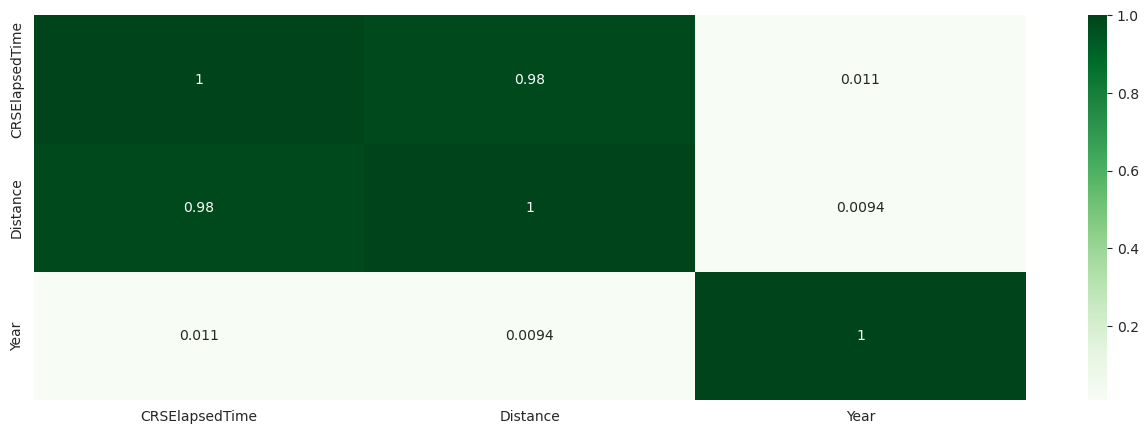

In [42]:
# Correlation Matrix for continuous variables
plot_corr_matrix(sdf_cleaned)

ScheduledArrTimeOfDay distribution:


+---------------------+-------+
|ScheduledArrTimeOfDay|  count|
+---------------------+-------+
|                    1|8101253|
|                    3|6829194|
|                    4|4674027|
|                    2|8734965|
+---------------------+-------+



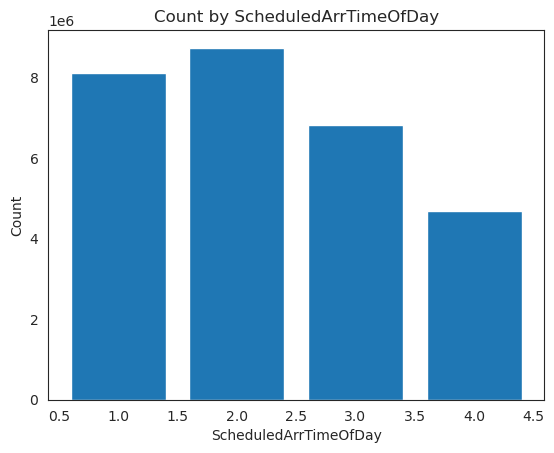

ScheduledDepTimeOfDay distribution:


+---------------------+--------+
|ScheduledDepTimeOfDay|   count|
+---------------------+--------+
|                    1|11765192|
|                    3| 6292175|
|                    4| 1754960|
|                    2| 8527112|
+---------------------+--------+



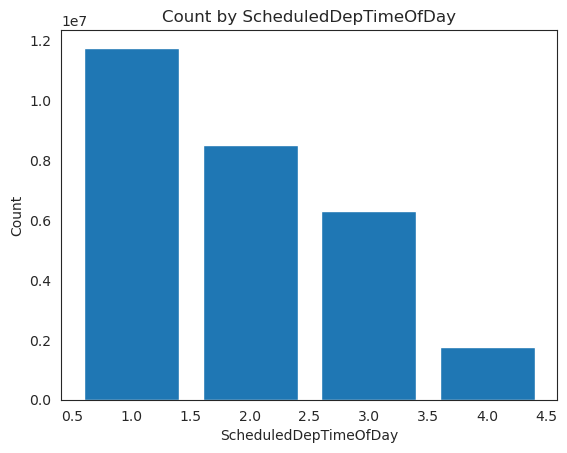

Season distribution:


+------+-------+
|Season|  count|
+------+-------+
|     1|7146439|
|     4|6715276|
|     2|7297150|
|     3|7180574|
+------+-------+



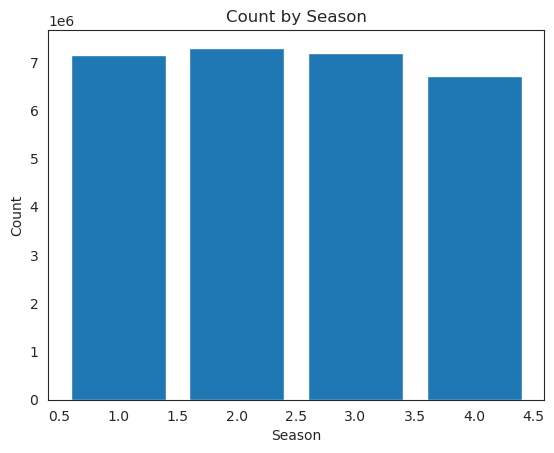

In [43]:
# Add feature columns and drop unneeded columns
sdf_features = add_features(sdf_cleaned)

In [44]:
# Define column names for the processing
# Categorical columns
categorical_columns = ["DayOfWeek", "Month", "Season", "DayofMonth", "Operating_Airline",
                        "OriginStateName", "DestStateName", 
                        "DistanceGroup", "ScheduledArrTimeOfDay", "ScheduledDepTimeOfDay"]

string_columns = ["Operating_Airline", "OriginStateName",
                "DestStateName", "DistanceGroup"]

other_categorical_columns = ["DayOfWeek", "Month", "Season", "DayofMonth", "ScheduledArrTimeOfDay", "ScheduledDepTimeOfDay"]

# Index columns
index_output_columns = ["Operating_AirlineIndex", "OriginStateNameIndex", 
                         "DestStateNameIndex", "DistanceGroupIndex"]

# One-hot encoding input and output columns
ohe_input_columns = index_output_columns + other_categorical_columns
ohe_output_columns = [
                        "Operating_AirlineVector",  "OriginStateNameVector", 
                        "DestStateNameVector", "DistanceGroupVector",
                        "DayOfWeekVector", "MonthVector", "SeasonVector", "DayofMonthVector", 
                        "ScheduledArrTimeOfDayVector", "ScheduledDepTimeOfDayVector"]

# Continuous columns
continuous_columns = ["CRSElapsedTime", "Distance"]
scaled_columns = ["CRSElapsedTimeScaled", "DistanceScaled"]

# Create the indexer for string-based columns
indexer = StringIndexer(inputCols=string_columns, outputCols=index_output_columns, handleInvalid="keep")

# Create the encoder for the indexed string columns and other categorical columns
encoder = OneHotEncoder(inputCols=ohe_input_columns, outputCols=ohe_output_columns, dropLast=True, handleInvalid="keep")

# Create an assembler for continuous columns
assembler = [VectorAssembler(inputCols=[col], outputCol=col + "Vector") for col in continuous_columns]

# Create a scaler for continuous columns (use the corresponding Vector column)
scaler = [MinMaxScaler(inputCol=col + "Vector", outputCol=scaled_col) for col, scaled_col in zip(continuous_columns, scaled_columns)]

# Final assembler 
final_assembler = VectorAssembler(inputCols=ohe_output_columns + scaled_columns, outputCol="features")
    
# Create pipeline
stages = [indexer, encoder] + assembler + scaler + [final_assembler]
pipeline = Pipeline(stages=stages)


In [45]:
# Split cleaned data into Training and Test Data
trainingData, testData = sdf_features.randomSplit([0.7, 0.3], seed=42)

In [46]:
# Fit and transform the Training and Test Data
training_transformed = pipeline.fit(trainingData).transform(trainingData)
test_transformed = pipeline.fit(testData).transform(testData)

# drop previous columns
columns_to_drop = [
    "Quarter", "DayOfWeek", "Month", "Season", "DayofMonth", "Operating_Airline", 
    "OriginAirportID", "OriginCityName", "OriginStateName", 
    "DestAirportID", "DestCityName", "DestStateName", 
    "DistanceGroup", "ScheduledArrTimeOfDay", "ScheduledDepTimeOfDay",
    "Operating_AirlineIndex", "OriginAirportIDIndex",
    "OriginStateNameIndex", "DestAirportIDIndex",  
    "DestStateNameIndex", "DistanceGroupIndex", 
    "CRSElapsedTime", "Distance", "Year", 
    "CRSElapsedTimeVector", "DistanceVector"]
training_transformed = training_transformed.drop(*columns_to_drop)
test_transformed = test_transformed.drop(*columns_to_drop)

/tmp/ipykernel_11182/2580371767.py:32: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=chi_df_top, y="Feature", x="Chi2 Statistic", palette="mako")


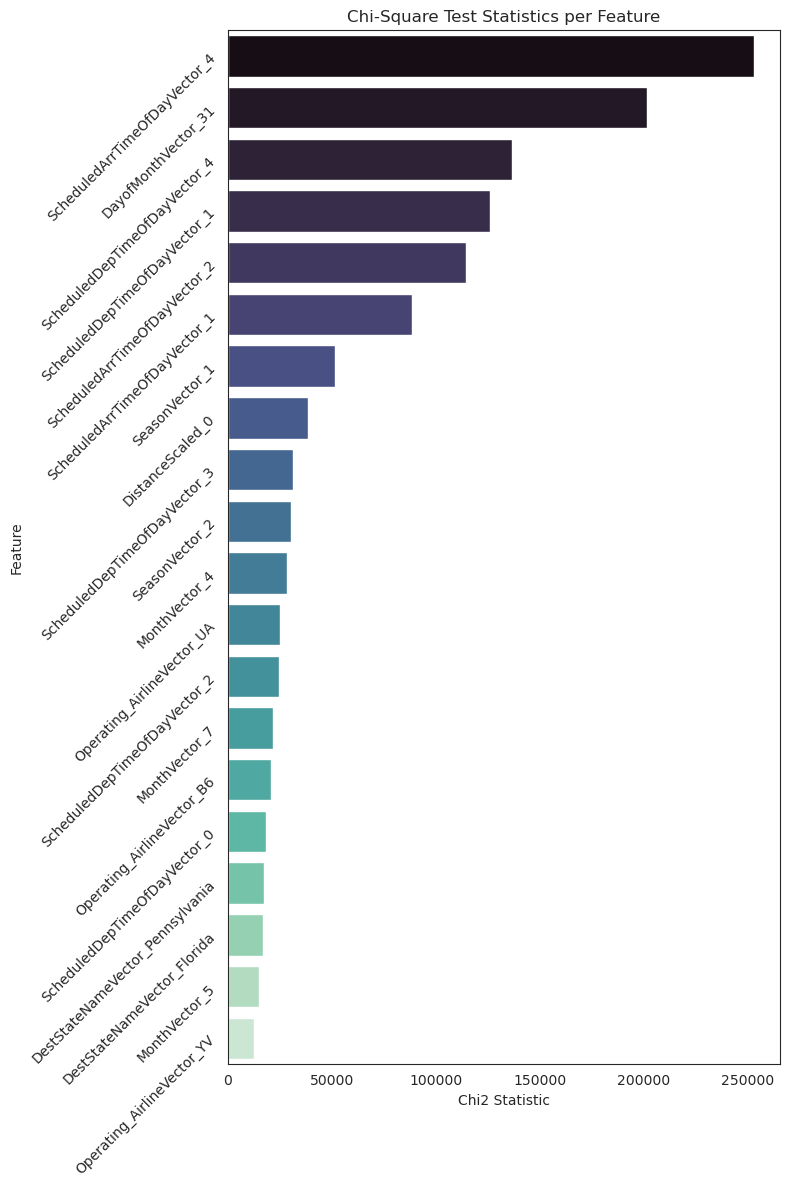

In [47]:
# Chi Squared for categorical variables 
from pyspark.ml.stat import ChiSquareTest

chi_sq_result = ChiSquareTest.test(training_transformed, "features", "label")
result_row = chi_sq_result.head()

attrs = training_transformed.schema["features"].metadata.get("ml_attr", {}).get("attrs", {})

# Flatten the structure (PySpark stores numeric and binary attrs separately)
feature_names = []

for attr_type in ["numeric", "binary"]:
    if attr_type in attrs:
        feature_names.extend([attr["name"] for attr in attrs[attr_type]])

# Extract values
p_values = result_row.pValues
chi2_stats = result_row.statistics

# Create DataFrame
chi_df = pd.DataFrame({
    "Feature": feature_names,
    "Chi2 Statistic": chi2_stats,
    "p-Value": p_values
}).sort_values("Chi2 Statistic", ascending=False)

# Show top features
chi_df_top = chi_df.head(20)

# Plot
plt.figure(figsize=(8, 12))
sns.barplot(data=chi_df_top, y="Feature", x="Chi2 Statistic", palette="mako")
plt.title("Chi-Square Test Statistics per Feature")
plt.yticks(rotation=45) 
plt.tight_layout()
plt.show()

In [48]:
print("Transformed Test Data Schema: ")
test_transformed.printSchema()
test_transformed.select('label','features').show(30, truncate=False)

Transformed Test Data Schema: 
root
 |-- label: integer (nullable = false)
 |-- Operating_AirlineVector: vector (nullable = true)
 |-- OriginStateNameVector: vector (nullable = true)
 |-- DestStateNameVector: vector (nullable = true)
 |-- DistanceGroupVector: vector (nullable = true)
 |-- DayOfWeekVector: vector (nullable = true)
 |-- MonthVector: vector (nullable = true)
 |-- SeasonVector: vector (nullable = true)
 |-- DayofMonthVector: vector (nullable = true)
 |-- ScheduledArrTimeOfDayVector: vector (nullable = true)
 |-- ScheduledDepTimeOfDayVector: vector (nullable = true)
 |-- CRSElapsedTimeScaled: vector (nullable = true)
 |-- DistanceScaled: vector (nullable = true)
 |-- features: vector (nullable = true)



+-----+----------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                |
+-----+----------------------------------------------------------------------------------------------------------------------------------------+
|1    |(219,[8,54,87,138,150,158,171,176,210,214,217,218],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.06326034063260341,0.08144561646204393])   |
|0    |(219,[8,33,87,140,150,158,171,176,209,214,217,218],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.03527980535279805,0.020058793014006572])  |
|0    |(219,[8,33,108,138,150,158,171,176,211,216,217,218],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.06690997566909976,0.08144561646204393])  |
|0    |(219,[8,33,87,140,150,158,171,176,208,213,217,218],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.03467153284671533,0.019712951

In [49]:
print("Transformed Training Data Schema: ")
training_transformed.printSchema()
training_transformed.select('label','features').show(30, truncate=False)

Transformed Training Data Schema: 
root
 |-- label: integer (nullable = false)
 |-- Operating_AirlineVector: vector (nullable = true)
 |-- OriginStateNameVector: vector (nullable = true)
 |-- DestStateNameVector: vector (nullable = true)
 |-- DistanceGroupVector: vector (nullable = true)
 |-- DayOfWeekVector: vector (nullable = true)
 |-- MonthVector: vector (nullable = true)
 |-- SeasonVector: vector (nullable = true)
 |-- DayofMonthVector: vector (nullable = true)
 |-- ScheduledArrTimeOfDayVector: vector (nullable = true)
 |-- ScheduledDepTimeOfDayVector: vector (nullable = true)
 |-- CRSElapsedTimeScaled: vector (nullable = true)
 |-- DistanceScaled: vector (nullable = true)
 |-- features: vector (nullable = true)



+-----+----------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                |
+-----+----------------------------------------------------------------------------------------------------------------------------------------+
|0    |(219,[8,33,87,140,150,158,171,176,208,213,217,218],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.03808353808353808,0.020058793014006572])  |
|0    |(219,[8,33,87,140,150,158,171,176,209,214,217,218],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.03931203931203931,0.020058793014006572])  |
|0    |(219,[8,54,87,138,150,158,171,176,208,213,217,218],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.06695331695331695,0.08144561646204393])   |
|1    |(219,[8,33,87,140,150,158,171,176,208,213,217,218],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.04361179361179361,0.019712951

In [50]:
# Save to /trusted folder
training_transformed.write.mode("overwrite").parquet("gs://my-project-bucket-flights-cl/trusted/training_data")
test_transformed.write.mode("overwrite").parquet("gs://my-project-bucket-flights-cl/trusted/test_data")

Build Model
1. Logistic Regression


In [3]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.linalg import VectorUDT

In [4]:
# Read saved data files
#training_transformed = spark.read.parquet("gs://my-project-bucket-flights-cl/trusted/training_data")
#test_transformed = spark.read.parquet("gs://my-project-bucket-flights-cl/trusted/test_data")

In [53]:
# Optional: Take a small sample of the data while developing the rest of the code
#training_transformed = training_transformed.sample(False, .25)
#training_transformed = training_transformed.sample(False, .25)


In [6]:
# cast to double for cross validator
training_transformed = training_transformed.withColumn("label", col("label").cast("double"))
test_transformed = test_transformed.withColumn("label", col("label").cast("double"))


In [55]:

# Create a LogisticRegression Estimator
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Fit the model to the training data - This can take a long time depending on the size of the data
model = lr.fit(training_transformed)

# Show model coefficients and intercept
print("Coefficients: ", model.coefficients)
print("Intercept: ", model.intercept)
# pd.DataFrame({'coefficients':model.coefficients, 'feature':list(pd.DataFrame(trainingData.schema["features"].metadata["ml_attr"]["attrs"]['numeric']).sort_values('idx')['name'])})

Coefficients:  [0.025998242185703076,-0.25437985070676317,-0.008079403744966162,0.06483523357083042,-0.11371385162948608,-0.13274281532843468,0.2580484546585143,0.009248934970786764,-0.34260063656323203,0.15642751008617792,0.13207876241716301,-0.027019921217240027,0.09154722070682009,0.24025560041826455,0.2645754251693182,0.07058076060805257,0.047538393389480085,-0.021157800301872632,0.1393399642959562,0.2699029959319959,0.0007276464260935025,0.3489179018823743,0.3900295175866927,0.20635116221688668,0.24931710994631326,0.48494143153508396,1.4949937648849208,-0.18665107083667593,0.0,-0.23350878632872585,0.029015459228725213,0.06383743425466801,0.23091016555750737,0.018165661980970898,0.25340425820509843,0.08719026267840928,0.0669584932315016,0.10857475939926324,-0.24949833304339433,-0.18154941850957218,0.027244575460505682,0.039162659480185165,-0.08759969732298252,0.5081012126763673,-0.08007100590124631,0.04990902140454095,-0.03668055909991044,0.17867296931611465,-0.24515370812785572,-0

In [56]:
# Test the model on the testData
test_results = model.transform(test_transformed)

# Show the test results
test_results.select('rawPrediction','probability','prediction', 'label').show(30, truncate=False)

# Show the confusion matrix
test_results.groupby('label').pivot('prediction').count().sort('label').show()

+----------------------------------------+----------------------------------------+----------+-----+
|rawPrediction                           |probability                             |prediction|label|
+----------------------------------------+----------------------------------------+----------+-----+
|[1.9795193415368757,-1.9795193415368757]|[0.8786299143115831,0.1213700856884169] |0.0       |0.0  |
|[1.600001345863988,-1.600001345863988]  |[0.8320185732368948,0.16798142676310523]|0.0       |0.0  |
|[1.8539471611885339,-1.8539471611885339]|[0.8645898791863253,0.13541012081367465]|0.0       |0.0  |
|[1.4353053951372976,-1.4353053951372976]|[0.8077266120680002,0.19227338793199977]|0.0       |0.0  |
|[1.491041616450245,-1.491041616450245]  |[0.8162345620377824,0.18376543796221756]|0.0       |0.0  |
|[1.1700752992121963,-1.1700752992121963]|[0.7631586261437273,0.23684137385627269]|0.0       |0.0  |
|[1.7233748444586086,-1.7233748444586086]|[0.8485630270816248,0.1514369729183752] |0.0     

+-----+-------+-----+
|label|    0.0|  1.0|
+-----+-------+-----+
|  0.0|6314383|11276|
|  1.0|2159057|13860|
+-----+-------+-----+



In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Flight Delay Prediction") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()


def calculate_recall_precision(confusion_matrix):
    tn = confusion_matrix[0][1]  # True Negative
    fp = confusion_matrix[0][2]  # False Positive
    fn = confusion_matrix[1][1]  # False Negative
    tp = confusion_matrix[1][2]  # True Positive
    precision = tp / ( tp + fp )            
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score


25/05/07 18:02:40 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [58]:
confusion_matrix = test_results.groupby('label').pivot('prediction').count().fillna(0).sort('label').collect()

print("Accuracy, Precision, Recall, F1 Score")
print( calculate_recall_precision(confusion_matrix) )

Accuracy, Precision, Recall, F1 Score
(0.744623922878374, 0.5514003819223424, 0.006378522511444293, 0.012611160877376477)


25/04/24 21:11:18 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
25/04/24 21:11:28 WARN DAGScheduler: Broadcasting large task binary with size 53.1 MiB
25/04/24 21:12:22 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


In [62]:
# Save to /models folder
lr.write().overwrite().save("gs://my-project-bucket-flights-cl/models/logistic_regression_model")

Logistic Regression n-Fold Validation and Hyperparameter Grid

In [8]:
# n-Fold Validation and Hyperparameter Grid

sc.setLogLevel("ERROR")

from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

# Create a LogisticRegression Estimator
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=5)

# Create a grid to hold hyperparameters 
grid = ParamGridBuilder()
grid = grid.addGrid(lr.regParam, [0.0, 0.3, 0.6, 1.0])
grid = grid.addGrid(lr.elasticNetParam, [0, 0.5, 1])

# Build the parameter grid
grid = grid.build()

# How many models to be tested
print('Number of models to be tested: ', len(grid))

# Create a BinaryClassificationEvaluator to evaluate how well the model works
BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

lr_pipe = Pipeline(stages=[lr])

evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

# Create the CrossValidator using the hyperparameter grid
cv = CrossValidator(estimator=lr_pipe, 
                    estimatorParamMaps=grid, 
                    evaluator=evaluator, 
                    numFolds=3,
                    seed = 42)

# Train the models
cv  = cv.fit(training_transformed)

Number of models to be tested:  12


In [12]:
# Test the predictions
predictions = cv.transform(test_transformed)

# Calculate AUC
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

# Create the confusion matrix
predictions.groupby('label').pivot('prediction').count().fillna(0).sort('label').show()
cm = predictions.groupby('label').pivot('prediction').count().fillna(0).collect()

def calculate_recall_precision(cm):
    tn = cm[0][1]                # True Negative
    fp = cm[0][2]                # False Positive
    fn = cm[1][1]                # False Negative
    tp = cm[1][2]                # True Positive
    precision = tp / ( tp + fp )            
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print("Accuracy, Precision, Recall, F1 Score")
print( calculate_recall_precision(cm) )


AUC: 0.6178446282930727


+-----+-------+-----+
|label|    0.0|  1.0|
+-----+-------+-----+
|  0.0|6317104| 8555|
|  1.0|2161817|11100|
+-----+-------+-----+



Accuracy, Precision, Recall, F1 Score
(0.2553806661257133, 0.4352582040193335, 0.0013524282608341676, 0.0026964780623937603)


In [15]:
# Define bucket and folder as constants
BUCKET_NAME = "my-project-bucket-flights-cl"  
FIGURE_FOLDER = 'figures'

def save_vis_to_gcs(fig, file_name):
    """
    Function to plot the frequency distribution of a column and save the plot to Google Cloud Storage.
    given fig and file name
    """

    # Create a buffer to hold the figure
    img_data = io.BytesIO()

    # Write the figure to the img_data buffer
    fig.savefig(img_data, format='png', bbox_inches='tight')

    # Rewind the pointer to the start of the data
    img_data.seek(0)

    # Connect to Google Cloud Storage
    storage_client = storage.Client()

    # Point to the bucket on Google Cloud Storage
    bucket = storage_client.get_bucket(BUCKET_NAME)

    # Create a blob to hold the data. Use the specific folder and file name format
    blob = bucket.blob(f"{FIGURE_FOLDER}/{file_name}.png")

    # Upload the img_data contents to the blob
    blob.upload_from_file(img_data)

    print(f"Plot saved to Google Cloud Storage at {FIGURE_FOLDER}/{file_name}.png")

Plot saved to Google Cloud Storage at figures/confusion_matrix_heatmap.png.png


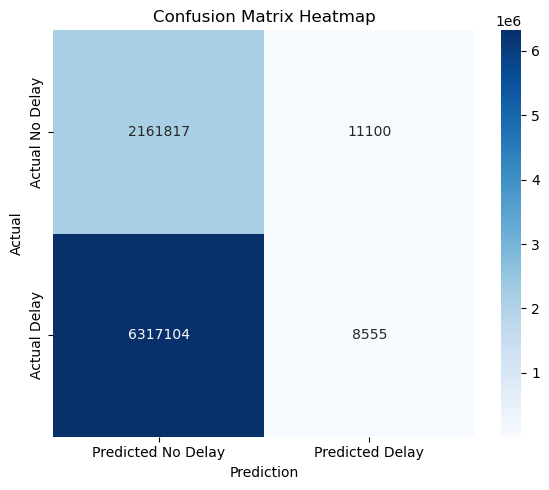

In [16]:
# Confusion Matrix
# Extract TN, FP, FN, TP from cm
tn = cm[0][1]                # True Negative
fp = cm[0][2]                # False Positive
fn = cm[1][1]                # False Negative
tp = cm[1][2]                # True Positive

conf_matrix = np.array([[tn, fp], [fn, tp]])

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted No Delay", "Predicted Delay"],
            yticklabels=["Actual No Delay", "Actual Delay"],
            ax=ax)
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix Heatmap")
fig.tight_layout()

# Save to GCS
save_vis_to_gcs(fig, "confusion_matrix_heatmap.png")

plt.show()

LogisticRegression_9b48cf8bd00e__aggregationDepth 2
LogisticRegression_9b48cf8bd00e__elasticNetParam 0.5
LogisticRegression_9b48cf8bd00e__family auto
LogisticRegression_9b48cf8bd00e__featuresCol features
LogisticRegression_9b48cf8bd00e__fitIntercept True
LogisticRegression_9b48cf8bd00e__labelCol label
LogisticRegression_9b48cf8bd00e__maxBlockSizeInMB 0.0
LogisticRegression_9b48cf8bd00e__maxIter 5
LogisticRegression_9b48cf8bd00e__predictionCol prediction
LogisticRegression_9b48cf8bd00e__probabilityCol probability
LogisticRegression_9b48cf8bd00e__rawPredictionCol rawPrediction
LogisticRegression_9b48cf8bd00e__regParam 0.0
LogisticRegression_9b48cf8bd00e__standardization True
LogisticRegression_9b48cf8bd00e__threshold 0.5
LogisticRegression_9b48cf8bd00e__tol 1e-06


Plot saved to Google Cloud Storage at figures/roc_curve.png.png


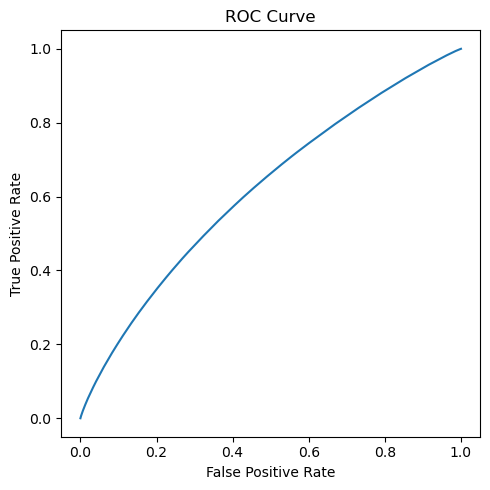

In [17]:
# Look at the parameters for the best model that was evaluated from the grid
parammap = cv.bestModel.stages[0].extractParamMap()

for p, v in parammap.items():
    print(p, v)

# Grab the model from Stage 3 of the pipeline (also can use index -1)
mymodel = cv.bestModel.stages[0]

# Extract ROC data
fpr = [row['FPR'] for row in mymodel.summary.roc.collect()]
tpr = [row['TPR'] for row in mymodel.summary.roc.collect()]

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')

fig.tight_layout()

# Save plot to GCS
save_vis_to_gcs(fig, "roc_curve.png")

plt.show()

In [71]:
hyperparams = cv.getEstimatorParamMaps()[np.argmax(cv.avgMetrics)]
# Print out the list of hyperparameters for the best model
for i in range(len(hyperparams.items())):
    print([x for x in hyperparams.items()][i])


(Param(parent='LogisticRegression_e18fac9a159a', name='regParam', doc='regularization parameter (>= 0).'), 0.0)
(Param(parent='LogisticRegression_e18fac9a159a', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'), 1.0)


In [19]:
# Extract the coefficients on each of the variables
coeff = mymodel.coefficients.toArray().tolist()

# Loop through the features to extract the original column names. Store in the var_index dictionary
var_index = dict()
for variable_type in ['numeric', 'binary']:
    for variable in predictions.schema["features"].metadata["ml_attr"]["attrs"][variable_type]:
         print(f"Found variable: {variable}" )
         idx = variable['idx']
         name = variable['name']
         var_index[idx] = name      # Add the name to the dictionary

# Loop through all of the variables found and print out the associated coefficients
for i in range(len(var_index)):
    print(f"Coefficient {i} {var_index[i]}  {coeff[i]}")



Found variable: {'idx': 217, 'name': 'CRSElapsedTimeScaled_0'}
Found variable: {'idx': 218, 'name': 'DistanceScaled_0'}
Found variable: {'idx': 0, 'name': 'Operating_AirlineVector_WN'}
Found variable: {'idx': 1, 'name': 'Operating_AirlineVector_DL'}
Found variable: {'idx': 2, 'name': 'Operating_AirlineVector_OO'}
Found variable: {'idx': 3, 'name': 'Operating_AirlineVector_AA'}
Found variable: {'idx': 4, 'name': 'Operating_AirlineVector_UA'}
Found variable: {'idx': 5, 'name': 'Operating_AirlineVector_YX'}
Found variable: {'idx': 6, 'name': 'Operating_AirlineVector_B6'}
Found variable: {'idx': 7, 'name': 'Operating_AirlineVector_MQ'}
Found variable: {'idx': 8, 'name': 'Operating_AirlineVector_9E'}
Found variable: {'idx': 9, 'name': 'Operating_AirlineVector_OH'}
Found variable: {'idx': 10, 'name': 'Operating_AirlineVector_AS'}
Found variable: {'idx': 11, 'name': 'Operating_AirlineVector_NK'}
Found variable: {'idx': 12, 'name': 'Operating_AirlineVector_YV'}
Found variable: {'idx': 13, 'nam

In [73]:
# Save to /models folder
cv.bestModel.write().overwrite().save("gs://my-project-bucket-flights-cl/models/best_lr_model")

/tmp/ipykernel_13714/3722634481.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], y=top_positive.index, x=top_positive['Coefficient'], palette='Greens_d')
/tmp/ipykernel_13714/3722634481.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], y=top_negative.index, x=top_negative['Coefficient'], palette='Reds_d')


Plot saved to Google Cloud Storage at figures/top_coefficients.png.png


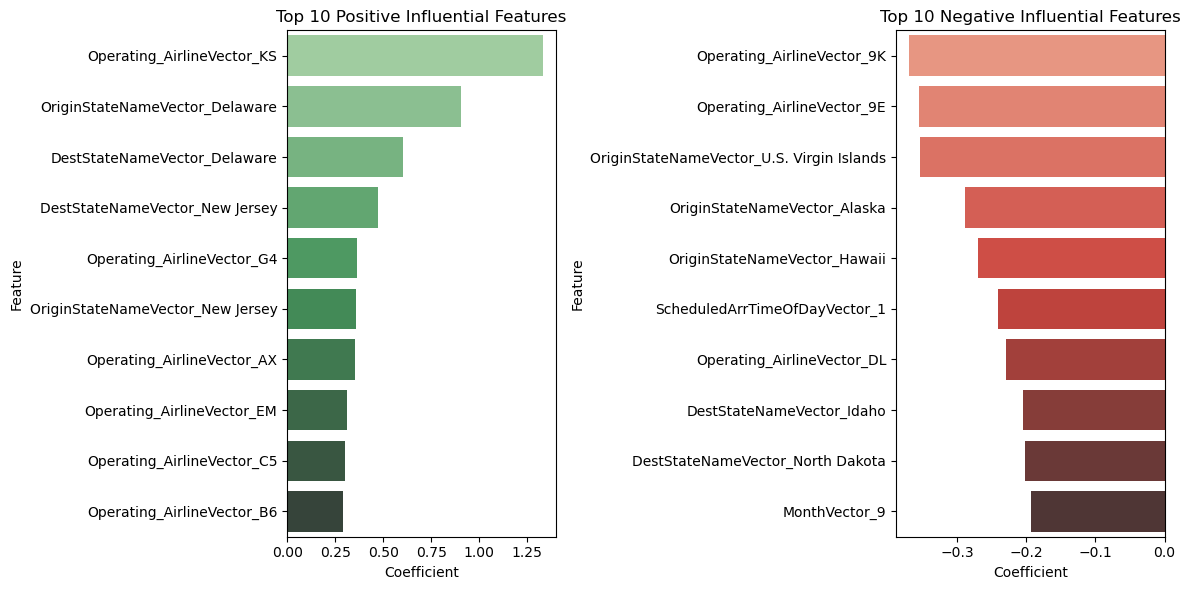

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
coef_data = [(var_index[i], coeff[i]) for i in range(len(var_index))]
coef_df = pd.DataFrame(coef_data, columns=['Feature', 'Coefficient']).set_index('Feature')

# Sort coefficients by magnitude for ranking
sorted_coefs = coef_df.sort_values(by='Coefficient', ascending=False)

# Top 10 positive and negative coefficients
top_positive = sorted_coefs.head(10)
top_negative = sorted_coefs.tail(10).sort_values(by='Coefficient')

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot top positive coefficients
sns.barplot(ax=axes[0], y=top_positive.index, x=top_positive['Coefficient'], palette='Greens_d')
axes[0].set_title('Top 10 Positive Influential Features')
axes[0].set_xlabel('Coefficient')
axes[0].set_ylabel('Feature')

# Plot top negative coefficients
sns.barplot(ax=axes[1], y=top_negative.index, x=top_negative['Coefficient'], palette='Reds_d')
axes[1].set_title('Top 10 Negative Influential Features')
axes[1].set_xlabel('Coefficient')
axes[1].set_ylabel('Feature')

fig.tight_layout()

# Save to GCS
save_vis_to_gcs(fig, "top_coefficients.png")
plt.show()

In [ ]:
# Random Forest

In [74]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Create a RandomForest Estimator
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

# Fit the model to the training data - This can take a long time depending on the size of the data
model = rf.fit(training_transformed)


In [ ]:
# Get feature importances
importances = model.featureImportances

print("Feature Importances (sparse vector):", importances)
print("Feature Importances (array):", importances.toArray())

Feature Importances (sparse vector): (219,[0,6,8,14,22,32,76,85,87,97,137,140,145,155,158,163,164,168,173,177,210,211,215,217,218],[0.018432655310894396,0.005195389317531831,0.00030976444470076213,0.009992522183492569,0.00017403572121828655,0.061910920531391786,1.8538275952249594e-05,0.0026348553687911276,0.1323756833266559,0.005480353243176177,0.04264760245507734,0.0035975704020457513,3.414264759211707e-06,0.008554290808525501,0.00043871343114096123,0.0001332948174710295,0.008705802181326269,0.001786498147188683,0.05750121359827755,0.002735763098142453,0.21885475910124566,0.11518451122375213,0.30260737591546577,0.0002708674728282081,0.000453605358948453])
Feature Importances (array): [1.84326553e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.19538932e-03 0.00000000e+00
 3.09764445e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.99252218e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

In [ ]:
# Test the model on the testData
test_results = model.transform(test_transformed)

# Show the test results
test_results.select('rawPrediction','probability','prediction', 'label').show(30, truncate=False)

# Show the confusion matrix
test_results.groupby('label').pivot('prediction').count().sort('label').show()

+---------------------------------------+----------------------------------------+----------+-----+
|rawPrediction                          |probability                             |prediction|label|
+---------------------------------------+----------------------------------------+----------+-----+
|[7.57406622637796,2.42593377362204]    |[0.757406622637796,0.242593377362204]   |0.0       |0.0  |
|[7.57406622637796,2.42593377362204]    |[0.757406622637796,0.242593377362204]   |0.0       |0.0  |
|[7.555977617948059,2.44402238205194]   |[0.755597761794806,0.24440223820519397] |0.0       |0.0  |
|[7.517639829097994,2.4823601709020062] |[0.7517639829097994,0.24823601709020063]|0.0       |0.0  |
|[7.57406622637796,2.42593377362204]    |[0.757406622637796,0.242593377362204]   |0.0       |0.0  |
|[7.3321616101978275,2.6678383898021716]|[0.7332161610197827,0.2667838389802172] |0.0       |0.0  |
|[7.57406622637796,2.42593377362204]    |[0.757406622637796,0.242593377362204]   |0.0       |0.0  |


+-----+-------+
|label|    0.0|
+-----+-------+
|  0.0|6325659|
|  1.0|2172917|
+-----+-------+



In [78]:
confusion_matrix = test_results.groupby('label').pivot('prediction').count().fillna(0).sort('label').collect()
print("Accuracy, Precision, Recall, F1 Score")
# print( calculate_recall_precision(confusion_matrix) )
# cannot calculate because model only predicted 0

Accuracy, Precision, Recall, F1 Score


IndexError: tuple index out of range

In [12]:
# Save to /models folder
# rf.save("gs://my-project-bucket-flights-cl/models/random_forest_model")